## Mini-Projet Multimédia

Kunli Deng  
Lin Shen  
Antony Le Coq  
Benjamin Deslandes

In [2]:
%matplotlib inline
from skimage import io, color, external, filters
import numpy

# Dithering en image avec Python

Dans ce projet, nous nous basons sur des méthodes utilisées pour le dithering en traitement d'image [comme dans cette méthode](http://michal.is/projects/image-dithering-in-matlab/). Ces méthodes fonctionnant sous Matlab, nous avons donc entrepris leur analyse et leur réécriture en méthodes Python.

## Outils

Pour le traitement d'image, nous utilisons principalement des outils SciPy comme NumPy ou Matplotlib, qui est utilisé pour l'affichage des images. Nous utilisons également skimage qui permet d'accéder à des méthodes notamment de conversion de couleur (grayscale) et du thresholding.

## Seuillage

Dans cette première partie, on expose deux méthodes basiques qui sont le seuillage fixé et le seuillage aléatoire.

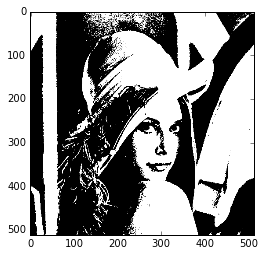

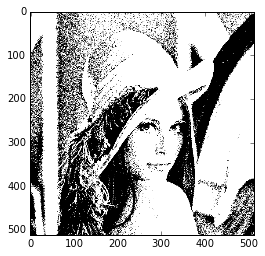

In [3]:
import matplotlib.pyplot as plt
import threshold


img = io.imread("lenna.png")
img_gray = color.rgb2gray(img)


bin_image_fixed = threshold.fixedThresholding(img_gray, 120/255)
plt.figure(1)
plt.imshow(bin_image_fixed, cmap='Greys_r')

bin_image_random = threshold.randomThresholding(img_gray, 0.3)
plt.figure(2)
plt.imshow(bin_image_random, cmap='Greys_r')

## Seuillage ordonné

Pour le seuillage ordonnée, au lieu de se baser sur une simple valeur de seuil, on a à la place une matrice, ici dans l'exemple que l'on récupère des sources Matlab, de dimension 6x6. Cette matrice est ensuite répliquée pour couvrir une matrice équivalente à la taille de l'image source.

La matrice utilisée dépend de la méthode et donc du résultat désirés.

In [7]:
def filtre(m,taille):
    result = numpy.zeros(taille)
    for i in range(taille[0]) :
        for j in range(taille[1]) :
            result[i][j] = m[i%m.shape[0]][j%m.shape[1]]
    return result

def quantification(img,m):
    return img*m.size

def ceuillage(imgQ, filtre):
    result = numpy.zeros(imgQ.shape)
    for i in range(imgQ.shape[0]) :
        for j in range(imgQ.shape[1]) :
            if (imgQ[i][j] <= filtre[i][j]) :
                result[i][j] = 0
            else :
                result[i][j] = 1
    return result

def orderedThreshold(img,m):
    #on charge l'image et on la transforme en niveau de gris
    img = io.imread(img)
    img_gray = color.rgb2gray(img)
    
    #on crée le filtre
    fil = filtre(m,img_gray.shape)
    
    #on quantifie les niveux de gris de l'image et on effectue le ceuillage
    imgQ = quantification(img_gray,m)
    result = ceuillage(imgQ,fil)
    
    return result


### Points en cluster

(<matplotlib.figure.Figure at 0xb516d37b8>,
 <matplotlib.image.AxesImage at 0xb52733eb8>)

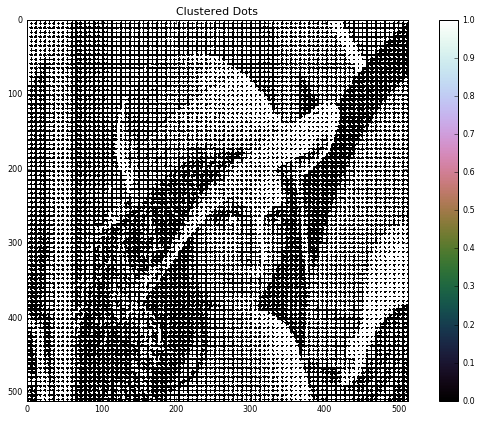

In [19]:
#Ordered threshold - Clustered dots
s1 = numpy.array([[34, 25, 21, 17, 29, 33],
                  [30, 13, 9 , 5 , 12, 24],
                  [18, 6 , 1 , 0 , 8 , 20],
                  [22, 10, 2 , 3 , 4 , 16],
                  [26, 14, 7 , 11, 15, 28],
                  [35, 31, 19, 23, 27, 32]])

#Affichage
result = orderedThreshold("Lenna.png",s1)
external.tifffile.imshow(result,title="Clustered Dots")

### Point blanc central

(<matplotlib.figure.Figure at 0xb528a0390>,
 <matplotlib.image.AxesImage at 0xb5139c550>)

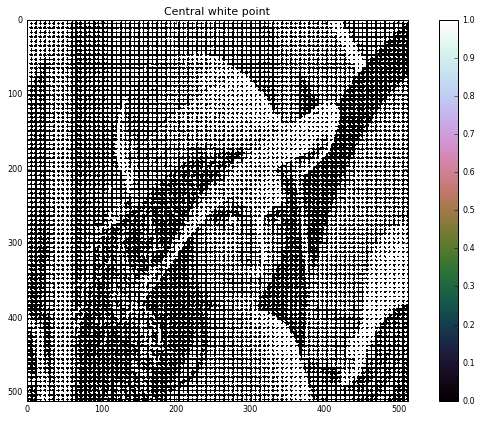

In [20]:
#Ordered matrix with central white point
s2 = numpy.array([[34, 25, 21, 17, 29, 33],
                  [30, 13, 9 , 5 , 12, 24],
                  [18, 6 , 1 , 0 , 8 , 20],
                  [22, 10, 2 , 3 , 4 , 16],
                  [26, 14, 7 , 11, 15, 28],
                  [35, 31, 19, 23, 27, 32]])

#Affichage
result = orderedThreshold("Lenna.png",s2)
external.tifffile.imshow(result,title="Central white point")

### Point centré équilibré

(<matplotlib.figure.Figure at 0xb526e51d0>,
 <matplotlib.image.AxesImage at 0xb525d3470>)

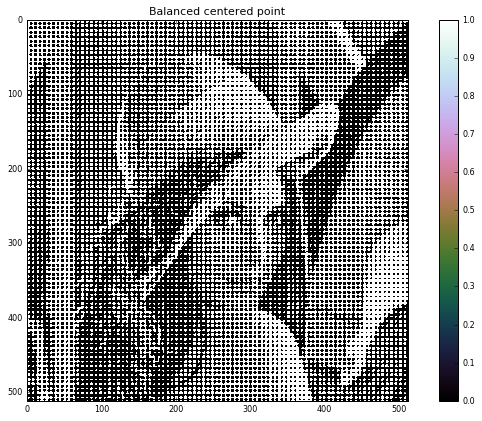

In [21]:
#Ordered matrix with balanced centered point
s3 = numpy.array([[30, 22, 16, 21, 33, 35],
		       [24, 11, 7 , 9 , 26, 28],
		       [13, 5 , 0 , 2 , 14, 19],
		       [15, 3 , 1 , 4 , 12, 18],
		       [27, 8 , 6 , 10, 25, 29],
		       [32, 20, 17, 23, 31, 34]])  

#Affichage
result = orderedThreshold("Lenna.png",s3)
external.tifffile.imshow(result,title="Balanced centered point")

## Diffusion d'erreur

Le principe de diffusion d'erreur est de créer une erreur entre l'image original (grayscale) et l'image seuillée pour chacun des pixels, pour pouvoir diffuser cette erreur aux pixels non traités selon un filtre qui se base sur une matrice. Il y a deux méthodes principales qui correspondent chacune à un filtre : Stucki et Floyd & Steinberg

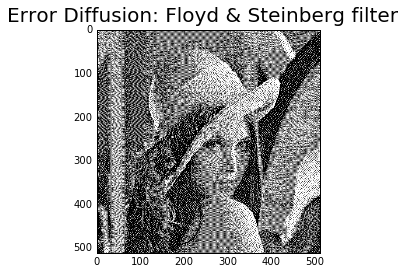

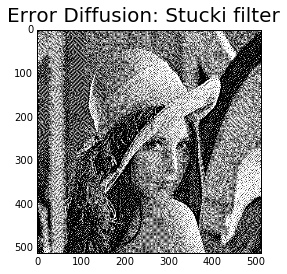

In [5]:
import matplotlib.pyplot as plt
import numpy as np

# Floyd & Steinberg filter
F1 = np.array([[0,0,7],
               [3,5,1]])
F1 = 1/F1.sum() * F1

# Stucki filter
F2 = np.array([[0,0,0,8,4],
               [2,4,8,4,2],
               [1,2,4,2,1]])
F2 = 1/F2.sum() * F2

# main function
#   input:
#       img: gray-scale image, 256 levels of grays, normalized to [0, 1]
#       filterName: name of the filter to be applied
#   output:
#       out: output image processed by error diffusion
def process(img, filterName):
    if filterName == "FloydSteinberg":
        F = F1
    elif filterName == "Stucki":
        F = F2
    else:
        F = F1
    threshold = 0.5
    out = np.zeros(img.shape)
    padDim1 = (0, F.shape[0] - 1)
    padDim2 = ( np.int(np.floor(F.shape[1]/2)), np.int(np.floor(F.shape[1]/2)) )
    I = np.lib.pad(img, (padDim1,padDim2), 'constant', constant_values=0)
    for y in range(padDim2[0], I.shape[1]-padDim2[1]):
        for x in range(0, I.shape[0]-padDim1[1]):
            ox = x
            oy = y - padDim2[0]

            # set the value in the corresponding pixel
            out[ox][oy] = I[x][y] > threshold

            # calculate the error
            error = I[x][y] - out[ox][oy]

            # get the block where the filter should be applied
            xmin = x
            xmax = x + F.shape[0] - 1
            ymin = y - np.int(np.floor(F.shape[1]/2))
            ymax = y + np.int(np.floor(F.shape[1]/2))

            # distribute the error
            I[xmin:xmax+1,ymin:ymax+1] = I[xmin:xmax+1,ymin:ymax+1] + error * F
    return out


# read lenna image
img = io.imread("lenna.png")

# transform to gray-scale, ranging [0, 1]
img_gray = color.rgb2gray(img)

diffused_image_floyd_steinberg = process(img_gray, "FloydSteinberg")
diffused_image_stucki = process(img_gray, "Stucki")
fig3 = plt.figure(0)
fig3.suptitle('Error Diffusion: Floyd & Steinberg filter', fontsize=20)
plt.imshow(diffused_image_floyd_steinberg, cmap='Greys_r')
fig4 = plt.figure(1)
fig4.suptitle('Error Diffusion: Stucki filter', fontsize=20)
plt.imshow(diffused_image_stucki, cmap='Greys_r')